In [1]:
import pandas as pd
from numpy import nan
import numpy as np
import matplotlib.pyplot as plt

import constant

# Windmill Preprocessing
## Clean and prepare windmill data for GIS

In [ ]:
# static cols
cols = ['GSRN','Turbine_type','Parent_GSRN','BBR_municipal','Placement','UTM_x','UTM_y','Capacity_kw','Rotor_diameter','Navhub_height','In_service','Out_service']

In [ ]:
windmills = pd.read_parquet('data/ITU_DATA/masterdatawind.parquet', columns=cols)

In [ ]:
windmills.sort_values(["In_service"])

### Select windmills still service

In [ ]:
windmills = windmills[windmills['Out_service'].isna()]
windmills = windmills.drop(columns = "Out_service")

### Remove duplicated data
Windmills have duplicated data by different reviewers.    

In [ ]:
windmills.drop_duplicates(subset = "GSRN", keep = 'first', ignore_index = True, inplace = True)

Household windmills has no coordinates, filter it out

In [ ]:
windmills = windmills[windmills['Turbine_type'] != 'H']

### Fill Turbine park xy by the CENTRIODs of their children's.
### Fill Turbine park Rotor_diameter, Navhub_height by the mean of their children's.

In [ ]:
windmills_M = windmills[windmills['Turbine_type'] == 'M']
aggs = {'UTM_x':lambda x : x.mean(),
        'UTM_y':lambda x : x.mean()}
windmills_PM = windmills_M.groupby(['Parent_GSRN'], as_index = False).agg(aggs).rename(columns={'Parent_GSRN':'GSRN','UTM_x':'x_c','UTM_y':'y_c'})

temp_1 = pd.DataFrame(windmills_M.groupby("Parent_GSRN")["Rotor_diameter"].apply(list)).reset_index()
temp_2 = pd.DataFrame(windmills_M.groupby("Parent_GSRN")["Navhub_height"].apply(list)).reset_index()
temp_1 = pd.merge(temp_1, temp_2, on="Parent_GSRN")
temp_1 = temp_1.rename({"Parent_GSRN":"GSRN","Rotor_diameter":"Rotor_diameter_mean", "Navhub_height":"Navhub_height_mean"}, axis=1)
temp_1["Rotor_diameter_mean"] = temp_1["Rotor_diameter_mean"].apply(lambda x: np.mean(x).astype(float))
temp_1["Navhub_height_mean"] = temp_1["Navhub_height_mean"].apply(lambda x: np.mean(x).astype(float))
windmills_PM = pd.merge(windmills_PM, temp_1, on="GSRN")
windmills_PM

In [ ]:
windmills = pd.merge(windmills, windmills_PM, on='GSRN', how='left')
# location
windmills[['UTM_x']] = windmills.apply(lambda x: x[['UTM_x']].fillna(value = x['x_c']), axis=1)[['UTM_x']]
windmills[['UTM_y']] = windmills.apply(lambda x: x[['UTM_y']].fillna(value = x['y_c']), axis=1)[['UTM_y']]
windmills[['Rotor_diameter']] = windmills.apply(lambda x: x[['Rotor_diameter']].fillna(value = x['Rotor_diameter_mean']), axis=1)[['Rotor_diameter']]
windmills[['Navhub_height']] = windmills.apply(lambda x: x[['Navhub_height']].fillna(value = x['Navhub_height_mean']), axis=1)[['Navhub_height']]
windmills = windmills.drop(columns=['x_c','y_c','Rotor_diameter_mean','Navhub_height_mean'])

Filter out other no coordinate windmills or parks

In [ ]:
windmills = windmills[~windmills['UTM_x'].isnull()]
windmills = windmills[~windmills['UTM_y'].isnull()]
windmills.shape

- H: Household turbine : No UTM_xy locations 
- W: Single turbine : full data
- P: Turbine park : No UTM_xy locations
- M: Turbine in a park : No power record in settlement data


In [ ]:
print('Household: ',windmills[windmills['Turbine_type'] == 'H'].shape)
print('Single: ',windmills[windmills['Turbine_type'] == 'W'].shape)
print('Park: ',windmills[windmills['Turbine_type'] == 'P'].shape)
print('In a Park: ',windmills[windmills['Turbine_type'] == 'M'].shape)

Cause a bug in ArcGIS file import, we need to add a 'z' at the end of GSRN and Parent_GSRN

In [ ]:
windmills['GSRN'] = [x+'z' for x in windmills['GSRN']]
windmills['Parent_GSRN'].fillna('',inplace = True)
windmills['Parent_GSRN'] = [x+'z' for x in windmills['Parent_GSRN']]

In [ ]:
windmills.to_csv('data/windmill_gis.csv', index=False)

## After ArcGIS data extraction 
Merge data

In [31]:
windmills_gis = pd.read_excel('data/windmill_extract.xlsx')
windmills_gis.head(3)

,OBJECTID,GSRN,Turbine_type,Parent_GSRN,BBR_municipal,Placement,UTM_x,UTM_y,Capacity_kw,Rotor_diameter,Navhub_height,In_service,Aspect,Slope,Elevation,grid,LABEL3,Landcover
0,1,570714700000005619z,W,z,330,LAND,642278.20,6134407.00,55.0,16.0,18.0,1984-11-24,225.0,3.035724,23.0,817,Non-irrigated arable land,211
1,2,570715000000049002z,M,570715000000048869z,550,LAND,478674.48,6099264.00,600.0,42.0,45.0,1995-05-03,45.0,1.012750,12.0,1190,Non-irrigated arable land,211
2,3,570715000000055430z,W,z,430,LAND,572444.17,6106876.88,225.0,27.0,30.0,1993-10-28,135.0,1.012750,46.0,940,Non-irrigated arable land,211


In [32]:
windmills_gis["Aspect"] = windmills_gis["Aspect"]*(np.pi/180)

In [34]:
windmills_grid = pd.read_excel('data/windmill_grid.xlsx')[["GSRN","grid"]]
windmills_grid.head(3)

,GSRN,grid
0,570715000000052248z,857.0
1,570715000000056024z,1235.0
2,570715000000036705z,1326.0


In [35]:
windmills_grid = windmills_grid[~windmills_grid['grid'].isna()]

In [36]:
windmills_grid['grid'] = windmills_grid['grid'].apply(int)
windmills_grid["GSRN"] = windmills_grid["GSRN"].apply(str)

In [37]:
windmills = pd.read_csv('data/windmill_gis.csv')
windmills.head(3)

,GSRN,Turbine_type,Parent_GSRN,BBR_municipal,Placement,UTM_x,UTM_y,Capacity_kw,Rotor_diameter,Navhub_height,In_service
0,570714700000000027z,M,570714700000050459z,101,LAND,720898.353,6171174.877,225.0,27.0,30.0,1993-02-03
1,570714700000000034z,M,570714700000050459z,101,LAND,720993.352,6171226.877,225.0,27.0,30.0,1993-02-03
2,570714700000000041z,M,570714700000050466z,101,LAND,727504.304,6178385.864,600.0,44.0,50.0,1996-07-11


In [38]:
windmills = pd.merge(windmills, windmills_grid, on="GSRN", how='inner')
len(windmills)

6902

In [39]:
cols = ['GSRN', 'Aspect', 'Slope', 'Elevation', 'Landcover']
windmills = pd.merge(windmills, windmills_gis[cols], on="GSRN", how='left')
len(windmills)

6902

In [40]:
windmills["GSRN"] = windmills["GSRN"].apply(str)
windmills["Parent_GSRN"] = windmills["Parent_GSRN"].apply(str)
windmills["GSRN"] = windmills["GSRN"].apply(lambda x : x[:len(x)-1])
windmills["Parent_GSRN"] = windmills["Parent_GSRN"].apply(lambda x : x[:len(x)-1])

In [41]:
windmills["Landcover"] = windmills["Landcover"].fillna(-1)
windmills["Landcover"] = windmills["Landcover"].apply(int)

In [42]:
roughness_dic = {112:0.1, 121:0.1, 123:0.1, 131:0.0005,  133:0.1, 142:0.1,211:0.005, 222:0.05, 231:0.03, 242:0.3,243:0.3, 312:0.5, 313:0.5, 321:0.03, 322:0.03, 324:0.6, 331:0.0003, 411:0.005, 412:0.0005, 421:0.005, 423:0.0005, 512:0.000001,523:0.000001, -1:0.000001}

In [44]:
windmills['Roughness'] = windmills['Landcover'].apply(lambda x: roughness_dic[x])

In [45]:
windmills['Slope'] = round(windmills['Slope'],3)
windmills['Aspect'] = round(windmills['Aspect'],3)
windmills['Elevation'] = round(windmills['Elevation'],3)
windmills.fillna({'Slope':0, 'Aspect':-1, 'Elevation':0}, inplace=True)
windmills = windmills.drop(columns=["Landcover"])

In [46]:
windmills.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6902 entries, 0 to 6901
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   GSRN            6902 non-null   object 
 1   Turbine_type    6902 non-null   object 
 2   Parent_GSRN     6902 non-null   object 
 3   BBR_municipal   6902 non-null   int64  
 4   Placement       6902 non-null   object 
 5   UTM_x           6902 non-null   float64
 6   UTM_y           6902 non-null   float64
 7   Capacity_kw     6902 non-null   float64
 8   Rotor_diameter  6861 non-null   float64
 9   Navhub_height   6902 non-null   float64
 10  In_service      6900 non-null   object 
 11  grid            6902 non-null   int64  
 12  Aspect          6902 non-null   float64
 13  Slope           6902 non-null   float64
 14  Elevation       6902 non-null   float64
 15  Roughness       6902 non-null   float64
dtypes: float64(9), int64(2), object(5)
memory usage: 916.7+ KB


In [47]:
windmills.to_csv('data/windmill_cleaned.csv', index=False)

# Extract 2019 yearly max VAERDI

In [48]:
dtype = {"GSRN":str, "Turbine_type":str, "Parent_GSRN":str, "BBR_municipal":int, "Placement": str, "Capacity_kw":float, "Rotor_diameter":float, "Navhub_height":float, "Elevation":float, "Slope":float, "Aspect":float, "grid":int, "Roughness":float}
windmills = pd.read_csv('data/windmill_cleaned.csv', dtype=dtype)

In [49]:
len(windmills)

6902

In [50]:
settlement = pd.read_parquet(constant.settlement_2019_path)

In [51]:
settlement = settlement[settlement["GSRN"].isin(windmills["GSRN"].to_list())]
settlement

,GSRN,VAERDI,TIME_CET
0,570715000000023965,330.300,2019-01-27 19:00:00
1,570715000000023965,103.900,2019-01-27 20:00:00
2,570715000000051241,2.800,2019-04-16 15:00:00
3,570715000000023965,60.600,2019-01-27 21:00:00
4,570715000000023965,7.000,2019-01-27 22:00:00
...,...,...,...
45563225,570715000000017704,2.537,2019-12-30 21:00:00
45563226,570715000000017704,3.166,2019-12-30 22:00:00
45563227,570715000000017704,5.250,2019-12-30 23:00:00
45563228,570715000000017704,3.718,2019-12-31 00:00:00


In [52]:
settlement = settlement.groupby("GSRN", as_index=False)["VAERDI"].max().rename({"VAERDI":"max_VAERDI"}, axis=1)

In [53]:
windmills = pd.merge(windmills, settlement, on="GSRN")

In [54]:
len(windmills)

3614

In [55]:
len(np.unique(settlement["GSRN"]))

3614

### Filter max_VAERDI>0

In [56]:
windmills = windmills[windmills["max_VAERDI"] > 0]

In [57]:
windmills["max_VAERDI"] = round(windmills["max_VAERDI"],0)
windmills[["max_VAERDI"]] = windmills[["max_VAERDI"]].apply(lambda x: round(x / 10**(len(str(int(x)))-1), 0) * 10**(len(str(int(x)))-1), axis=1)


In [58]:
windmills

,GSRN,Turbine_type,Parent_GSRN,BBR_municipal,Placement,UTM_x,UTM_y,Capacity_kw,Rotor_diameter,Navhub_height,In_service,grid,Aspect,Slope,Elevation,Roughness,max_VAERDI
0,570714700000000140,W,NaN,167,LAND,719970.0,6167337.0,660.0,47.0,40.0,2000-05-18,652,-0.017,0.000,2.0,0.100,700.0
1,570714700000000157,W,NaN,167,LAND,720031.0,6167484.0,660.0,47.0,40.0,2000-05-18,652,-0.017,0.000,2.0,0.100,700.0
2,570714700000000317,W,NaN,219,LAND,704171.0,6199826.0,660.0,47.0,40.0,2001-05-14,696,-0.017,0.000,21.0,0.005,700.0
3,570714700000000324,W,NaN,219,LAND,704221.0,6199967.0,660.0,47.0,40.0,2001-05-14,696,1.571,1.432,20.0,0.005,700.0
4,570714700000000331,W,NaN,219,LAND,704272.0,6200109.0,660.0,47.0,40.0,2001-05-14,696,-0.017,0.000,19.0,0.005,700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3609,571313174001699887,W,NaN,360,LAND,644782.0,6073093.0,3600.0,126.0,87.0,2018-02-13,771,-0.017,0.000,1.0,0.005,4000.0
3610,571313174001699894,W,NaN,360,LAND,644459.0,6073175.0,3600.0,126.0,87.0,2018-02-08,771,-0.017,0.000,1.0,0.005,4000.0
3611,571313174001699900,W,NaN,360,LAND,644136.0,6073257.0,3600.0,126.0,87.0,2018-02-08,771,1.571,1.432,1.0,0.005,4000.0
3612,571313174001764448,W,NaN,320,LAND,702483.0,6132921.0,225.0,29.0,31.5,2018-11-21,650,-0.017,0.000,22.0,0.005,200.0


In [59]:
print('Household: ',windmills[windmills['Turbine_type'] == 'H'].shape)
print('In a Park: ',windmills[windmills['Turbine_type'] == 'M'].shape)
print('Single: ',windmills[windmills['Turbine_type'] == 'W'].shape)
print('Park: ',windmills[windmills['Turbine_type'] == 'P'].shape)

Household:  (0, 17)
In a Park:  (269, 17)
Single:  (3065, 17)
Park:  (242, 17)


In [60]:
print('Onshore Single: ',windmills[windmills['Turbine_type'] == 'W'][windmills['Placement'] == 'LAND'].shape)
print('Offshore Single: ',windmills[windmills['Turbine_type'] == 'W'][windmills['Placement'] == 'HAV'].shape)
print('Onshore Park: ',windmills[windmills['Turbine_type'] == 'P'][windmills['Placement'] == 'LAND'].shape)
print('Offshore Park: ',windmills[windmills['Turbine_type'] == 'P'][windmills['Placement'] == 'HAV'].shape)

Onshore Single:  (3049, 17)
Offshore Single:  (16, 17)
Onshore Park:  (229, 17)
Offshore Park:  (13, 17)


In [61]:
windmills.to_csv('data/windmill_cleaned.csv', index=False)

# Windmill Park Classify by max_VAERDI

In [62]:
dtype = {"GSRN":str, "Turbine_type":str, "Parent_GSRN":str, "BBR_municipal":int, "Placement": str, "Capacity_kw":float, "Rotor_diameter":float, "Navhub_height":float, "Elevation":float, "Slope":float, "Aspect":float, "grid":int, "Roughness":float}
windmills = pd.read_csv('data/windmill_cleaned.csv', dtype=dtype)

## Park and Land

In [63]:
windmill_PL = windmills[windmills["Turbine_type"]=="P"][windmills["Placement"]=="LAND"]
windmill_PL

,GSRN,Turbine_type,Parent_GSRN,BBR_municipal,Placement,UTM_x,UTM_y,Capacity_kw,Rotor_diameter,Navhub_height,In_service,grid,Aspect,Slope,Elevation,Roughness,max_VAERDI
554,570714700000050039,P,NaN,316,LAND,674395.333333,6.184767e+06,600.0,27.0,30.0,1991-01-01,779,4.712,1.432,6.0,0.005,700.0
555,570714700000050046,P,NaN,316,LAND,674289.000000,6.184966e+06,400.0,27.0,30.0,1991-01-01,779,-0.017,0.000,7.0,0.005,400.0
556,570714700000050077,P,NaN,265,LAND,689270.000000,6.168825e+06,900.0,31.0,30.0,1994-07-14,736,-0.017,0.000,43.0,0.005,900.0
557,570714700000050084,P,NaN,161,LAND,702392.666667,6.163966e+06,900.0,31.0,30.0,1993-09-21,694,3.283,5.051,30.0,0.005,900.0
558,570714700000050091,P,NaN,265,LAND,691963.000000,6.165674e+06,1500.0,39.0,40.5,1994-11-16,736,5.498,1.013,39.0,0.005,1000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2808,570715000000064470,P,NaN,707,LAND,577279.000000,6.260666e+06,4500.0,64.0,60.0,2002-12-17,1075,-0.017,0.000,1.0,0.005,1000.0
2809,570715000000064487,P,NaN,707,LAND,576787.000000,6.261446e+06,4500.0,64.0,60.0,2002-12-17,1075,5.498,1.013,0.0,0.005,1000.0
2810,570715000000064494,P,NaN,707,LAND,576822.000000,6.262148e+06,3000.0,64.0,60.0,2002-12-17,1075,-0.017,0.000,0.0,0.005,800.0
2838,570715000000080883,P,NaN,326,LAND,627577.100000,6.175889e+06,150.0,15.0,18.0,2006-02-03,861,2.678,6.379,56.0,0.005,90.0


In [64]:
len(windmill_PL)

229

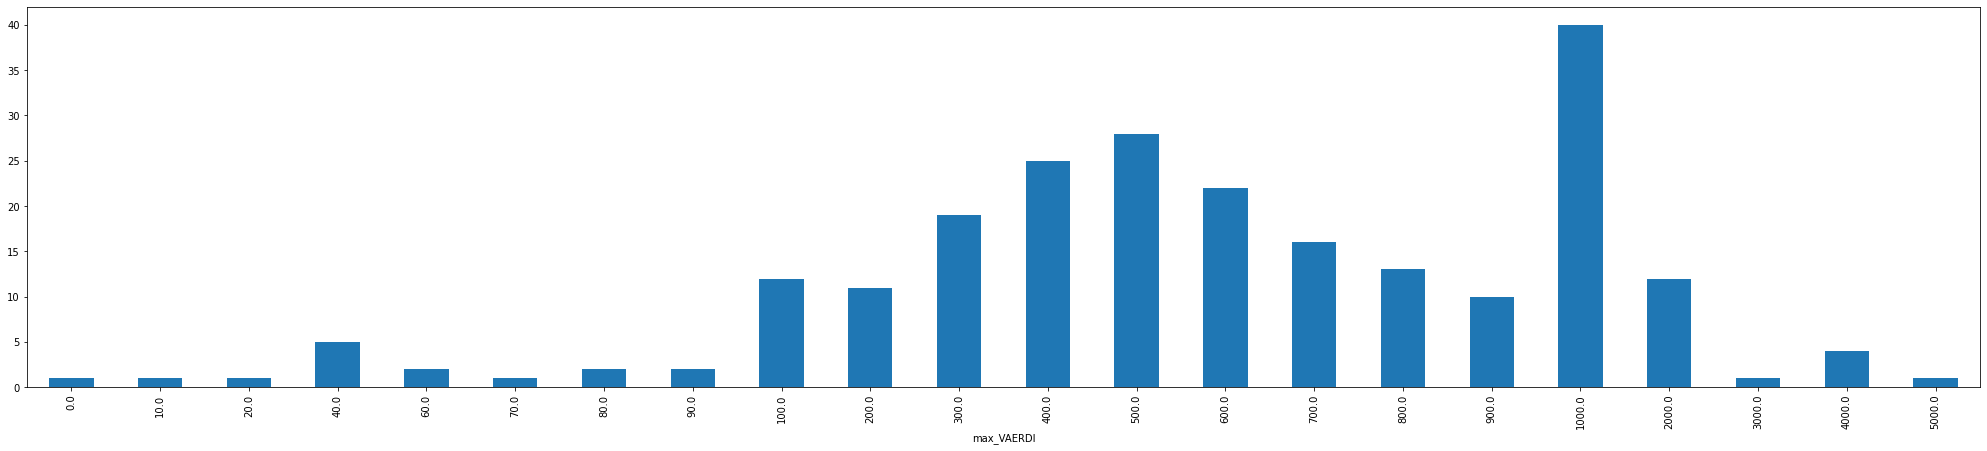

In [65]:
plt.figure(figsize=(35,7))
windmill_PL.groupby("max_VAERDI").count()["GSRN"].plot.bar()

In [66]:
windmill_PL_SC = windmill_PL[windmill_PL["max_VAERDI"] == 500]
len(windmill_PL_SC)

28

In [67]:
from tools import normalize_zcenter, normalize_maxmin

In [68]:
cols = ['Roughness', 'Slope', 'Aspect']
windmill_PL_SC_geo = windmill_PL_SC.copy()
windmill_PL_SC_geo[cols] = normalize_maxmin(windmill_PL_SC[cols])

In [69]:
windmill_PL_SC_geo[cols].describe()

,Roughness,Slope,Aspect
count,28.000000,28.000000,28.000000
mean,0.035714,0.292411,0.369240
std,0.188982,0.300026,0.369224
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.313565,0.317135
75%,0.000000,0.470115,0.688350
max,1.000000,1.000000,1.000000


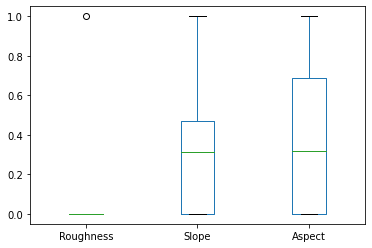

In [70]:
windmill_PL_SC_geo[cols].plot.box()

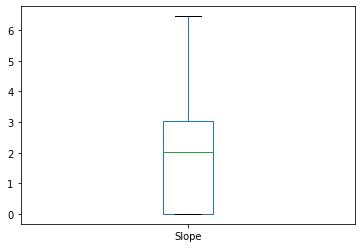

In [8]:
windmill_PL_SC_geo["Slope"].plot.box()

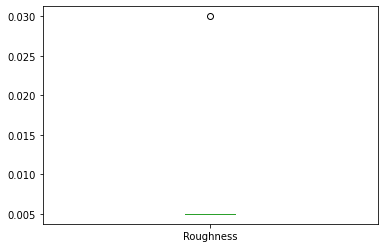

In [9]:
windmill_PL_SC_geo["Roughness"].plot.box()

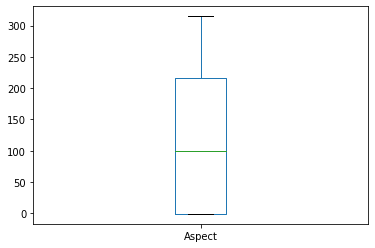

In [10]:
windmill_PL_SC_geo["Aspect"].plot.box()

In [71]:
windmill_PL_SC.to_csv('data/windmill_PL_SC.csv', index=False)

# Park and Hav

In [72]:
windmill_PH = windmills[windmills["Turbine_type"]=="P"][windmills["Placement"]=="HAV"]
windmill_PH

,GSRN,Turbine_type,Parent_GSRN,BBR_municipal,Placement,UTM_x,UTM_y,Capacity_kw,Rotor_diameter,Navhub_height,In_service,grid,Aspect,Slope,Elevation,Roughness,max_VAERDI
582,570714700000050442,P,NaN,101,HAV,730693.761000,6.176932e+06,20000.0,76.0,64.0,2000-12-27,653,-1.000,0.0,0.0,0.000001,20000.0
585,570714700000050473,P,NaN,101,HAV,730597.242000,6.178754e+06,20000.0,76.0,64.0,2000-12-27,653,-1.000,0.0,0.0,0.000001,20000.0
590,570714700000050619,P,NaN,360,HAV,675503.387681,6.047824e+06,165600.0,82.4,68.8,2003-06-17,686,-1.000,0.0,0.0,0.000001,200000.0
1437,570715000000023965,P,NaN,727,HAV,584590.760000,6.203445e+06,5000.0,39.0,45.0,1995-05-30,988,-1.000,0.0,0.0,0.000001,1000.0
2740,570715000000061752,P,NaN,561,HAV,426733.000000,6.149502e+06,160000.0,80.0,70.0,2002-07-29,1360,-1.000,0.0,0.0,0.000001,40000.0
2741,570715000000062582,P,NaN,665,HAV,452081.817500,6.280558e+06,8000.0,80.0,78.0,2002-12-22,1368,-0.017,0.0,0.0,0.000001,2000.0
2742,570715000000062636,P,NaN,665,HAV,452393.940000,6.279459e+06,9200.0,82.4,78.8,2003-01-21,1368,-0.017,0.0,0.0,0.000001,2000.0
2884,570715000000086489,P,NaN,561,HAV,410813.087912,6.162455e+06,209300.0,93.0,55.0,2009-05-13,1403,-1.000,0.0,0.0,0.000001,50000.0
2934,570715000000088735,P,NaN,330,HAV,624318.064286,6.134789e+06,21000.0,90.0,80.0,2009-10-28,859,-0.017,0.0,0.0,0.000001,5000.0
2944,570715000000089299,P,NaN,360,HAV,664492.611111,6.048460e+06,207000.0,92.6,80.0,2010-04-01,686,-1.000,0.0,0.0,0.000001,50000.0


In [73]:
len(windmill_PH)

13

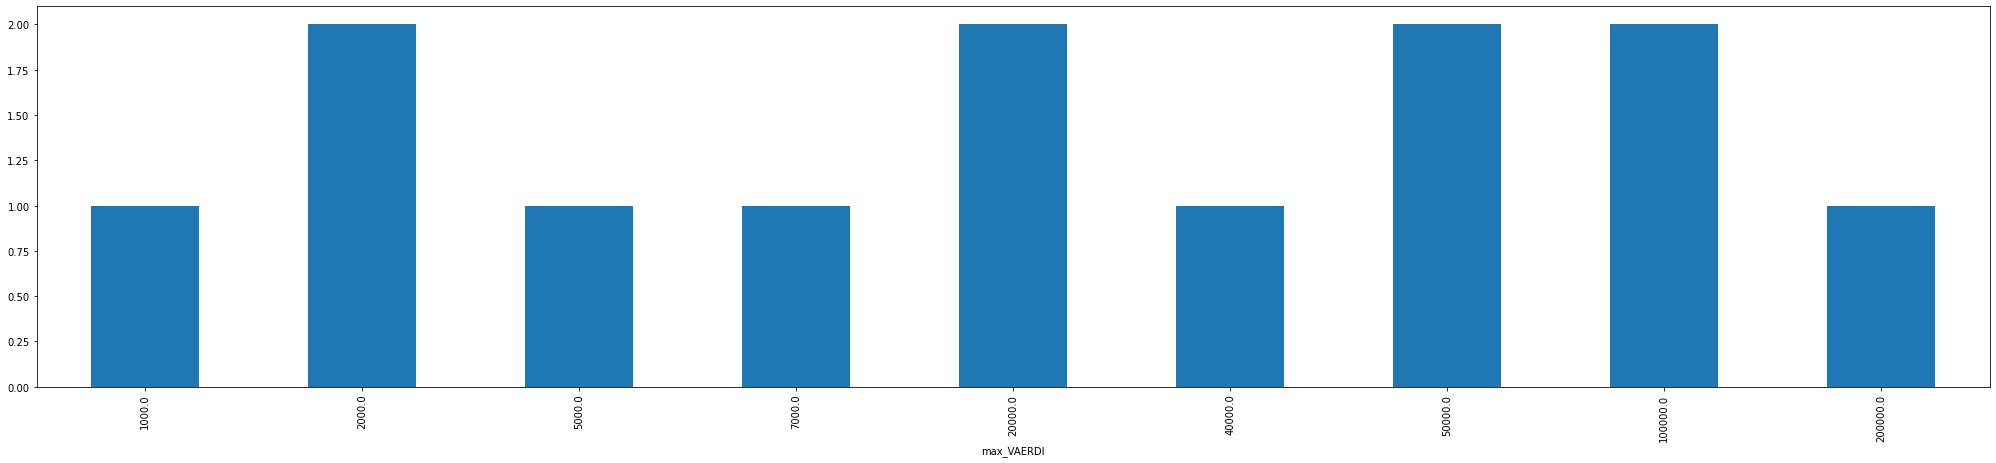

In [74]:
plt.figure(figsize=(35,7))
windmill_PH.groupby("max_VAERDI").count()["GSRN"].plot.bar()


In [75]:
windmill_PH_SC = windmill_PH[windmill_PH["max_VAERDI"] == 20000]
len(windmill_PH_SC)

2

In [76]:
windmill_PH_SC.to_csv('data/windmill_PH_SC.csv', index=False)

# Windmill Single Classify by max_VAERDI

In [96]:
windmills = pd.read_csv('data/windmill_cleaned.csv', dtype=dtype)

## Single and LAND

In [106]:
windmill_SL = windmills[windmills["Placement"] == "LAND"][windmills["Turbine_type"] == "W"].reset_index(drop=True)
windmill_SL.to_csv("data/windmill_SL.csv", index=False)
len(windmill_SL)

3049

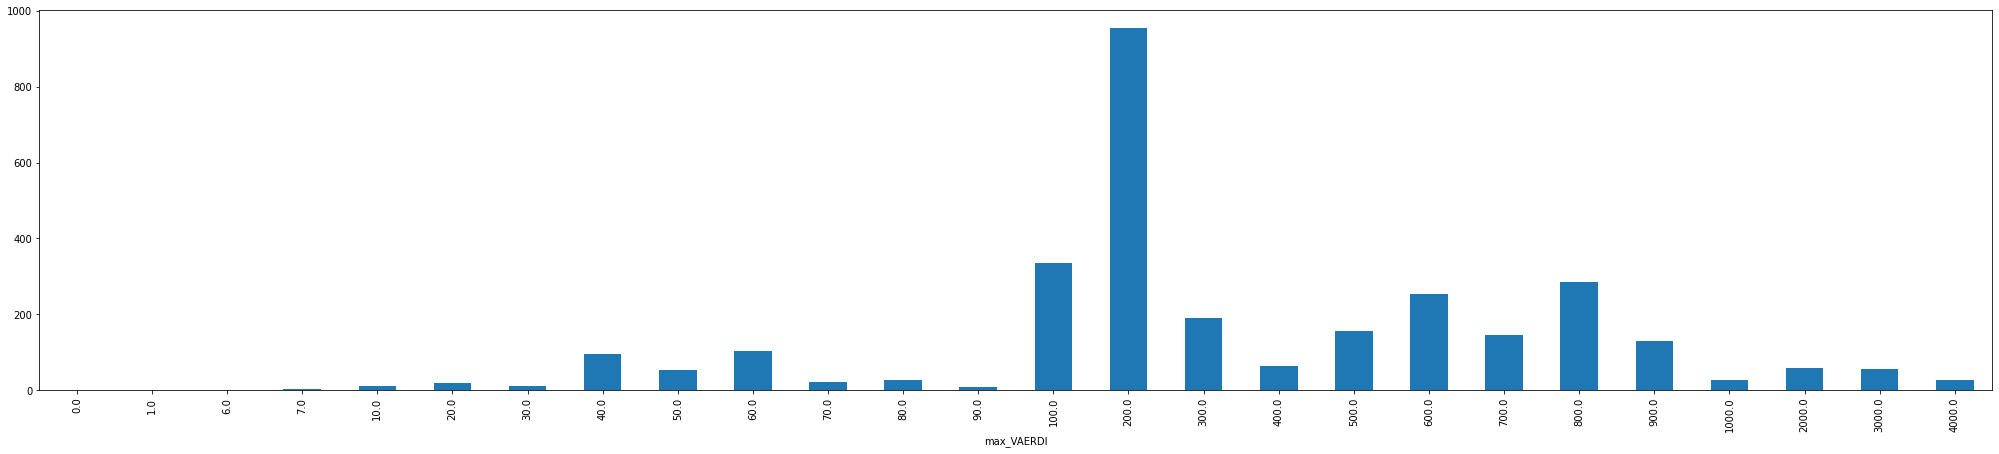

In [98]:
plt.figure(figsize=(35,7))
windmill_SL.groupby("max_VAERDI").count()["GSRN"].plot.bar()

### Select max_VAERDI == 200

In [102]:
windmill_SL_SC = windmill_SL[windmill_SL["max_VAERDI"] == 200]
len(windmill_SL_SC)

955

In [103]:
cols = ['Roughness', 'Slope', 'Aspect']
windmill_SL_SC_geo = windmill_SL.copy()
# windmill_SL_SC_geo[cols] = normalize_maxmin(windmill_SL_SC_geo[cols])

In [104]:
windmill_SL_SC_geo[cols].describe()

,Roughness,Slope,Aspect
count,3049.000000,3049.000000,3049.000000
mean,0.022284,1.569824,1.818288
std,0.081432,1.702122,2.047483
min,0.000001,0.000000,-1.000000
25%,0.005000,0.000000,-0.017000
50%,0.005000,1.013000,0.785000
75%,0.005000,2.862000,3.762000
max,0.600000,15.346000,6.173000


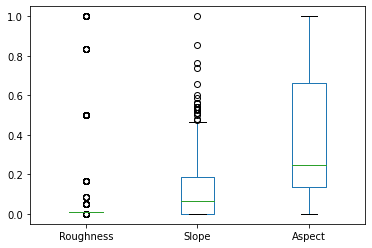

In [95]:
windmill_SL_SC_geo[cols].plot.box()

In [83]:
windmill_SL_SC.to_csv("data/windmill_SL_SC.csv", index=False)

## Single and Hav

In [85]:
windmill_SH = windmills[windmills["Placement"] == "HAV"][windmills["Turbine_type"] == "W"].reset_index(drop=True)
len(windmill_SH)

16

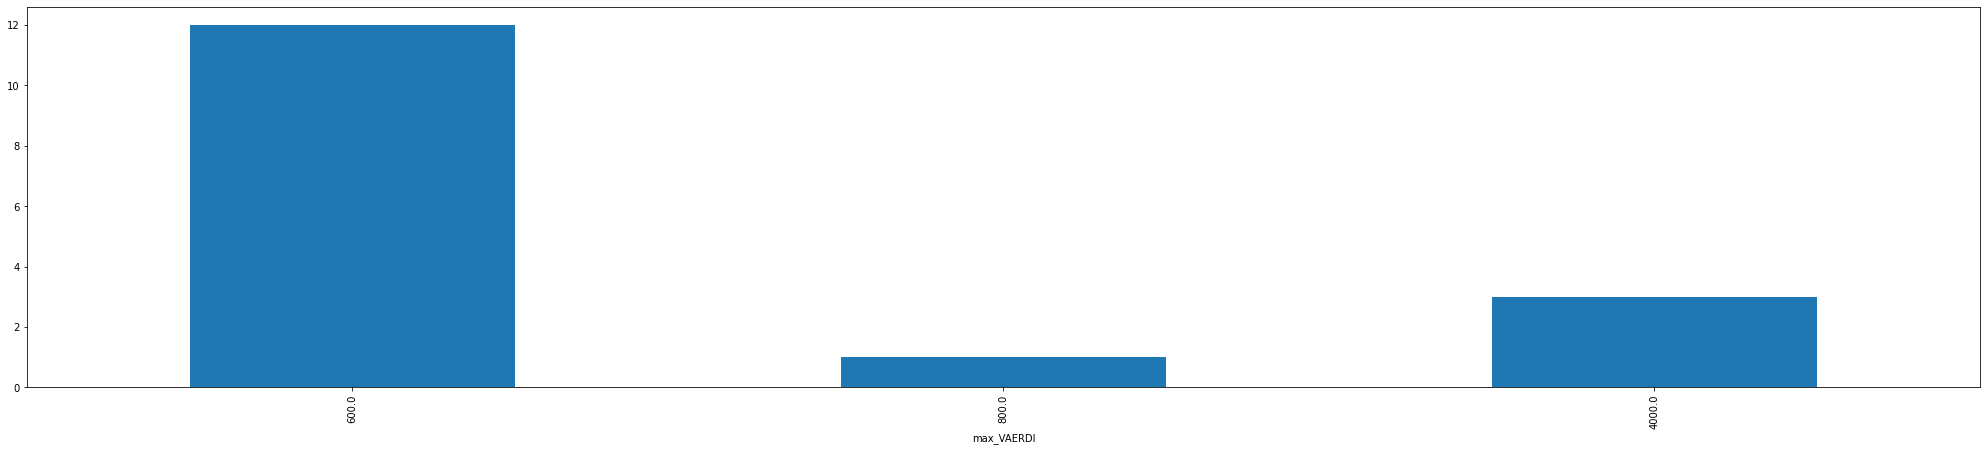

In [86]:
plt.figure(figsize=(35,7))
windmill_SH.groupby("max_VAERDI").count()["GSRN"].plot.bar()

In [87]:
windmill_SH_SC = windmill_SH[windmill_SH["max_VAERDI"] == 600]
len(windmill_SH_SC)

12

In [88]:
windmill_SH_SC.to_csv("data/windmill_SH_SC.csv", index=False)